# Load Libraries
## Upload the line in root directory. Change the filename with yours in the cell below.

In [2]:
!pip install prophet pycaret

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

energy_consumption = pd.read_csv('/content/energy_consumption_data.csv')

energy_consumption['timestamp'] = pd.to_datetime(energy_consumption['timestamp'])
energy_consumption['timestamp_as_hourly_int'] = energy_consumption['timestamp'].dt.hour

# Sort the data by timestamp
energy_consumption = energy_consumption.sort_values('timestamp')

# Feature engineering
# Create lag features
energy_consumption['lag_1'] = energy_consumption['energy_consumption'].shift(1)
energy_consumption['lag_2'] = energy_consumption['energy_consumption'].shift(2)
energy_consumption['lag_24'] = energy_consumption['energy_consumption'].shift(24)

# Create rolling mean and standard deviation features
energy_consumption['rolling_mean_3'] = energy_consumption['energy_consumption'].rolling(window=3).mean()
energy_consumption['rolling_std_3'] = energy_consumption['energy_consumption'].rolling(window=3).std()

# Create time-based features
energy_consumption['day_of_week'] = energy_consumption['timestamp'].dt.dayofweek
energy_consumption['hour_of_day'] = energy_consumption['timestamp'].dt.hour
energy_consumption['is_weekend'] = energy_consumption['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop rows with NaN values generated by shifting and rolling operations
energy_consumption = energy_consumption.dropna()
energy_consumption.head(5)




,timestamp,temperature,humidity,energy_consumption,timestamp_as_hourly_int,lag_1,lag_2,lag_24,rolling_mean_3,rolling_std_3,day_of_week,hour_of_day,is_weekend
24,2023-01-02 00:00:00,34.785803,70.003123,231.549495,0,263.948048,438.373099,188.996850,311.290214,111.242803,0,0,0
25,2023-01-02 01:00:00,1.656593,34.663233,248.253445,1,231.549495,263.948048,187.986857,247.916996,16.201897,0,1,0
26,2023-01-02 02:00:00,6.254165,29.762614,468.003101,2,248.253445,231.549495,196.385911,315.935347,131.959111,0,2,0
27,2023-01-02 03:00:00,2.294826,80.870272,122.298189,3,468.003101,248.253445,140.063990,279.518245,174.960245,0,3,0
28,2023-01-02 04:00:00,10.629854,52.187692,485.509068,4,122.298189,468.003101,355.671271,358.603453,204.833464,0,4,0


# Seasonal Decompose (Additive)

1.   From below statistics data is being repeated in daily (24 hours) interval

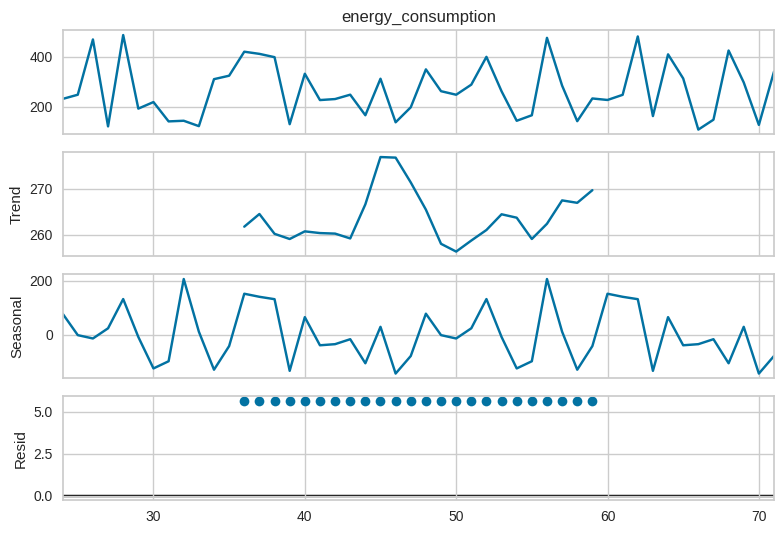

In [4]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(energy_consumption['energy_consumption'][:48], model='additive', period=24)

result.plot()
pyplot.show()

# Seasonal Decompose (Multiplicative)
1.   From below statistics data is being repeated in daily (24 hours) interval

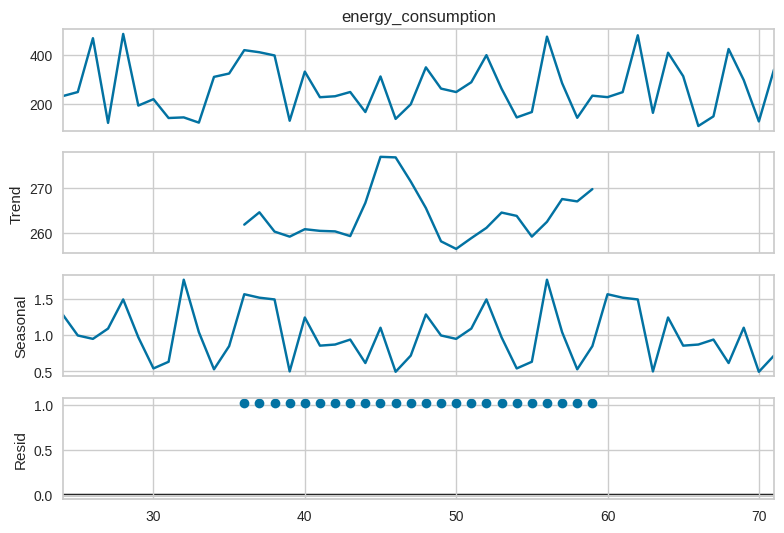

In [5]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(energy_consumption['energy_consumption'][:48], model='multiplicative', period=24)

result.plot()
pyplot.show()

#Box plot for daily consumption


1.   Morning to Midday Peak (7:00 AM - 2:00 PM): This is when energy consumption begins to rise and reaches its first peak, likely due to morning activities and business operations.

2.   Evening Peak (6:00 PM - 8:00 PM): Another significant peak occurs, driven by residential activities, with a noticeable increase in energy consumption around 7:00 PM.

3.   Low Consumption Period (Midnight - 6:00 AM): This period shows the lowest and most consistent energy consumption, typical of nighttime when most activities are minimal.





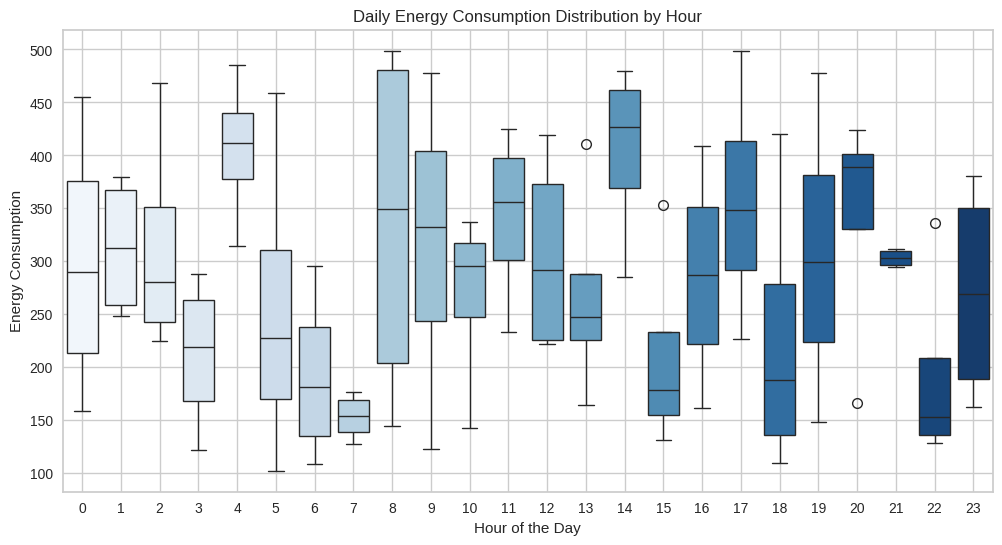

In [6]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(x='timestamp_as_hourly_int', y='energy_consumption', data=energy_consumption[:96], palette='Blues')
plt.title('Daily Energy Consumption Distribution by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()


#Using Prophet For Time-Series Forecasting

#Prophet for time series forecasting

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywmy3r0/nxxes9jv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprywmy3r0/b27ttloe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83272', 'data', 'file=/tmp/tmprywmy3r0/nxxes9jv.json', 'init=/tmp/tmprywmy3r0/b27ttloe.json', 'output', 'file=/tmp/tmprywmy3r0/prophet_model93vfc76q/prophet_model-20240813144113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


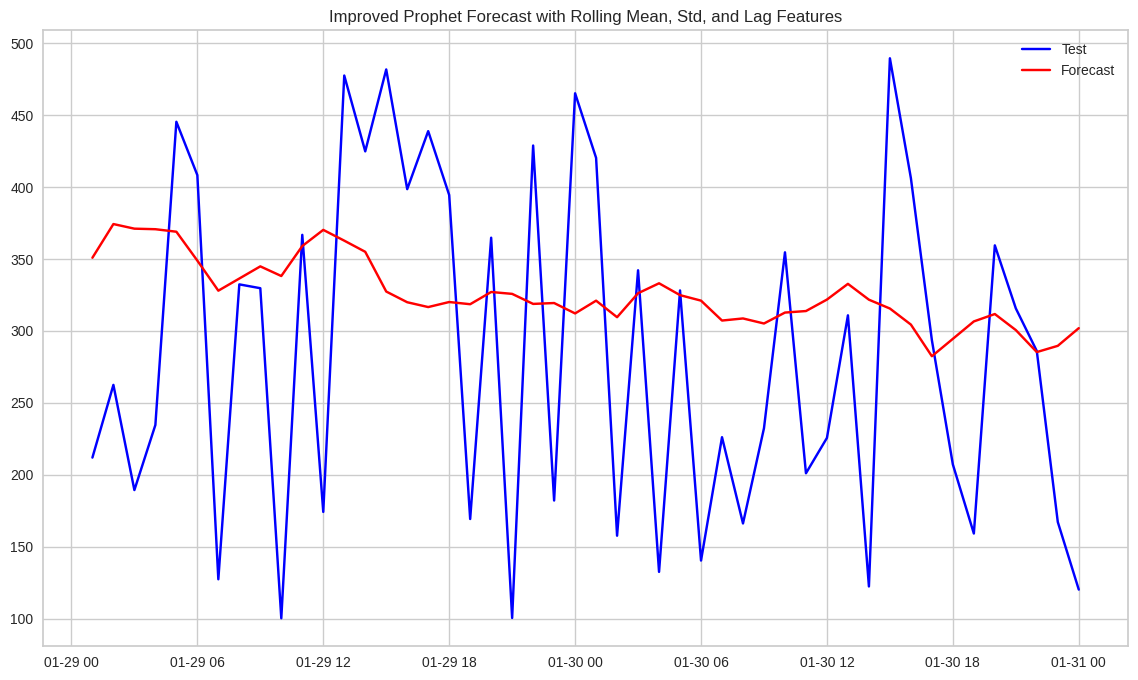

In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/energy_consumption_data.csv'
data = pd.read_csv(file_path)

# Prepare the data for Prophet
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.rename(columns={'timestamp': 'ds', 'energy_consumption': 'y'})

# Example of adding rolling mean and rolling standard deviation as features
data['rolling_mean_1h'] = data['y'].rolling(window=2).mean().shift(1)
data['rolling_std_1h'] = data['y'].rolling(window=2).std().shift(1)
data['lag_1h'] = data['y'].shift(1)

# Remove any NaN values created by the rolling operations
data = data.dropna()

# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Initialize the Prophet model with custom parameters
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.1,
    seasonality_mode='multiplicative'
)

# Add the rolling mean, rolling std, and lag features as regressors
model.add_regressor('rolling_mean_1h')
model.add_regressor('rolling_mean_1h')
model.add_regressor('lag_1h')

# Fit the model
model.fit(train)

# Make future predictions (matching the length of the test set)
future = model.make_future_dataframe(periods=len(test), freq='H')
future['rolling_mean_1h'] = data['rolling_mean_1h'].tail(len(future)).reset_index(drop=True)
future['rolling_std_1h'] = data['rolling_std_1h'].tail(len(future)).reset_index(drop=True)
future['lag_1h'] = data['lag_1h'].tail(len(future)).reset_index(drop=True)
forecast = model.predict(future)

# Plot the forecast
plt.figure(figsize=(14, 8))
plt.plot(test['ds'][-48:], test['y'][-48:], label='Test', color='blue')
plt.plot(forecast['ds'][-48:], forecast['yhat'][-48:], label='Forecast', color='red')
plt.title('Improved Prophet Forecast with Rolling Mean, Std, and Lag Features')
plt.legend()
plt.show()


#Checking Feature Importance (After installing pycaret - restart the kernel)

,Description,Value
0,Session id,42
1,Target,energy_consumption
2,Target type,Regression
3,Original data shape,"(557, 12)"
4,Transformed data shape,"(557, 14)"
5,Transformed train set shape,"(389, 14)"
6,Transformed test set shape,"(168, 14)"
7,Numeric features,10
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,3.1780
lar,Least Angle Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0780
br,Bayesian Ridge,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0740
par,Passive Aggressive Regressor,0.0530,0.0037,0.0605,1.0000,0.0003,0.0002,0.0880
huber,Huber Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.2660
ridge,Ridge Regression,1.8351,4.5321,2.1231,0.9997,0.0109,0.0079,0.0660
lasso,Lasso Regression,3.5363,17.1875,4.1328,0.9988,0.0208,0.0152,0.1480
llar,Lasso Least Angle Regression,3.5248,17.0706,4.1189,0.9988,0.0208,0.0152,0.0700
lightgbm,Light Gradient Boosting Machine,27.6835,1222.1982,34.6231,0.9128,0.1525,0.1170,0.1340
gbr,Gradient Boosting Regressor,30.0157,1441.2547,37.8090,0.8969,0.1558,0.1232,0.2480


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Mean,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


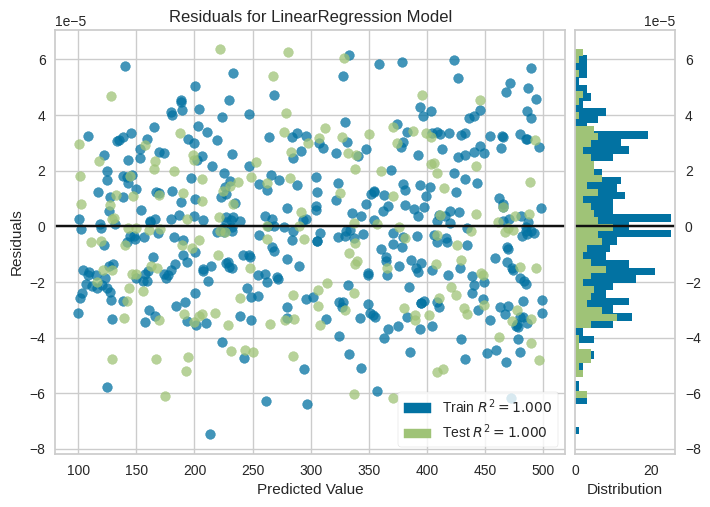

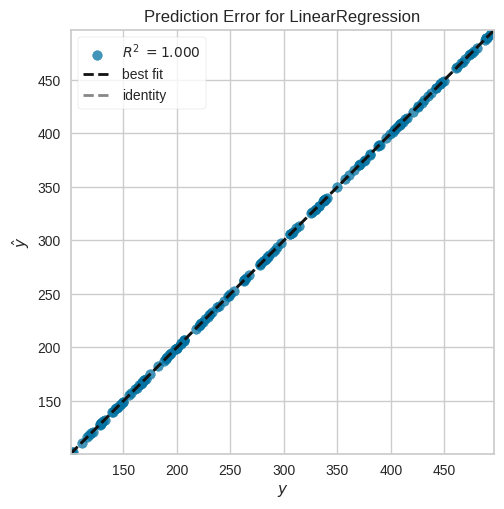

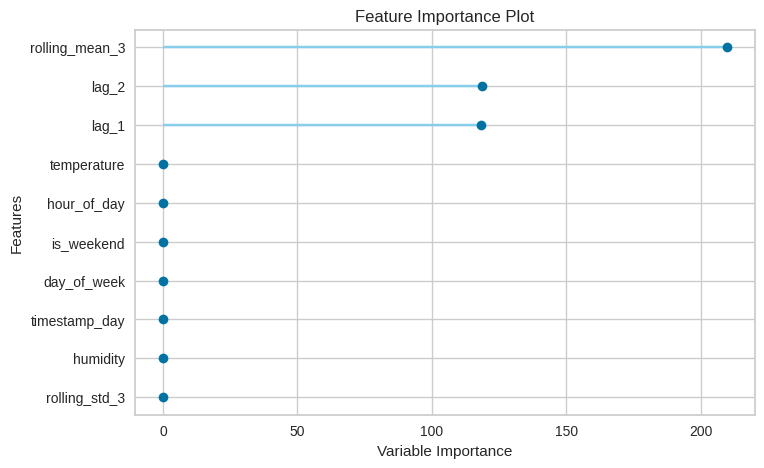

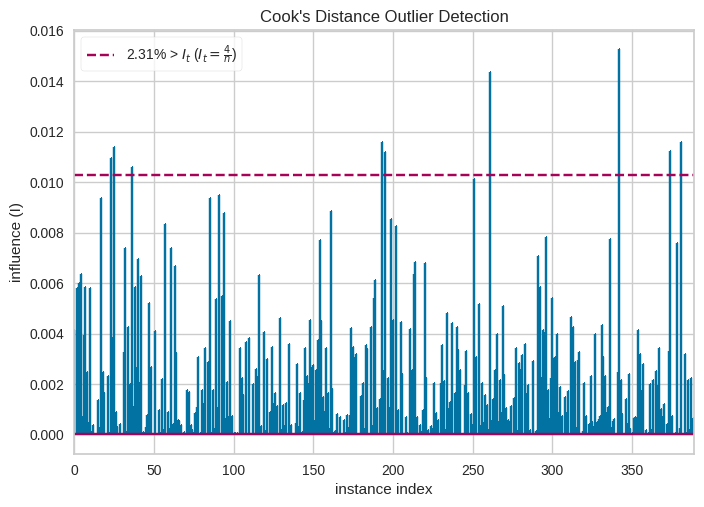

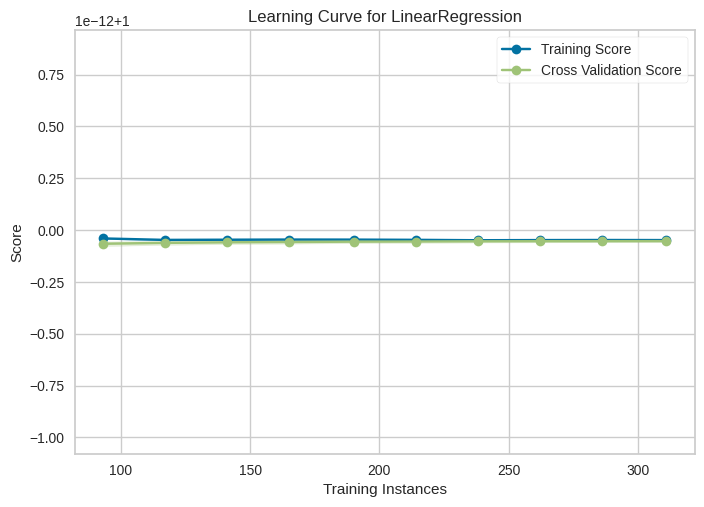

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pycaret.regression import setup, compare_models, tune_model, plot_model

# Split the data into training and testing sets
train_df, test_df = train_test_split(energy_consumption, test_size=0.2, random_state=42)

train_df = train_df.drop(columns=['timestamp_as_hourly_int'])

# Define X_test_df from test_df
X_test_df = test_df[['lag_1', 'lag_2', 'lag_24', 'rolling_mean_3', 'rolling_std_3', 'day_of_week', 'hour_of_day', 'is_weekend','temperature','humidity']]

# Set up the regression experiment with PyCaret using the training data
regression_setup = setup(data=train_df,
                         target='energy_consumption',
                         session_id=42,
                         normalize=True,
                         fold=5,
                         numeric_features=['lag_1', 'lag_2', 'lag_24', 'rolling_mean_3', 'rolling_std_3', 'day_of_week', 'hour_of_day', 'is_weekend','temperature','humidity'])

# Compare different models and select the best one
best_model = compare_models()

# Tune the selected model for better performance
tuned_model = tune_model(best_model)

# Generate and display various plots for the tuned model
plot_model(tuned_model, plot='residuals')       # Residuals plot
plot_model(tuned_model, plot='error')           # Prediction error plot
plot_model(tuned_model, plot='feature')         # Feature importance plot
plot_model(tuned_model, plot='cooks')           # Cooks distance plot
plot_model(tuned_model, plot='learning')        # Learning curve plot



# Feature relationship with energy consumption

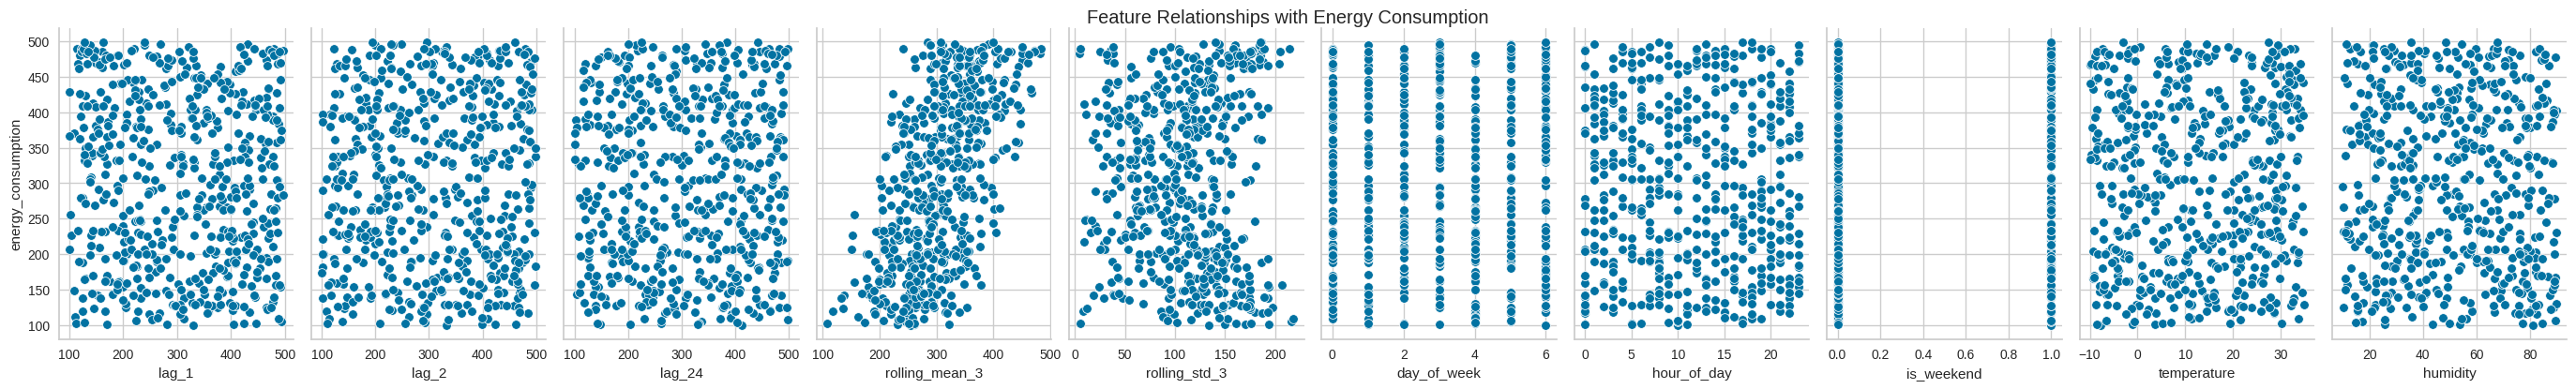

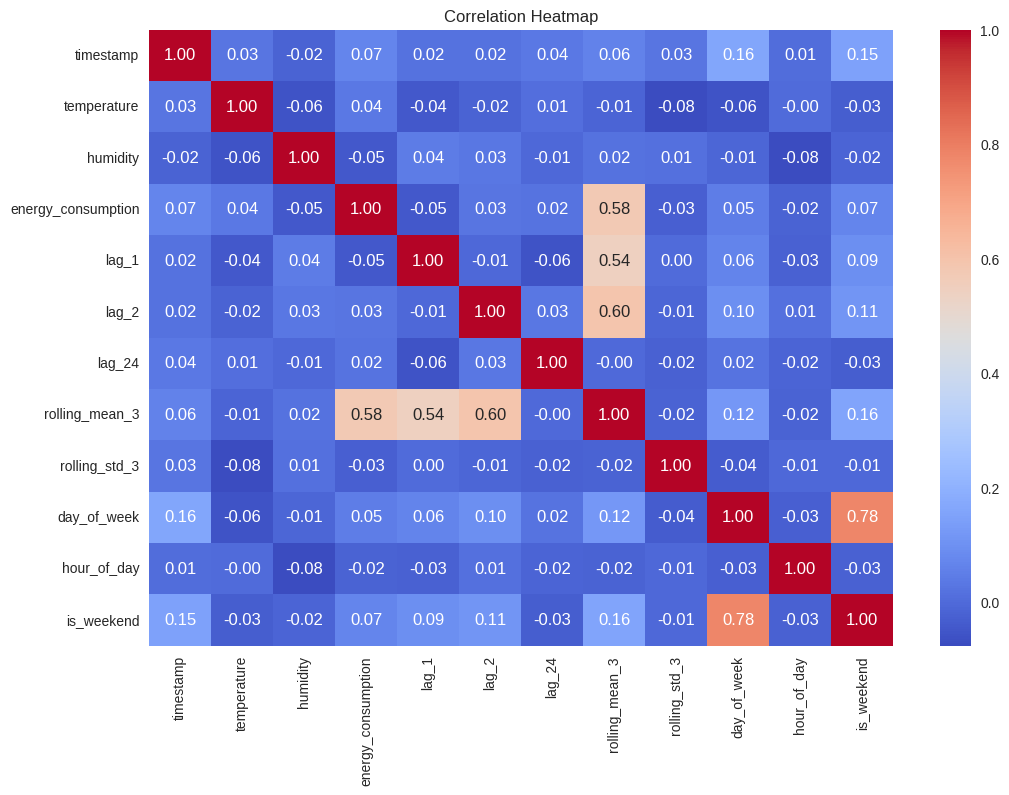

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(energy_consumption, test_size=0.2, random_state=42)

# Drop the 'timestamp_as_hourly_int' column as before
train_df = train_df.drop(columns=['timestamp_as_hourly_int'])

# Pairplot to visualize the relationships between features and the target variable
sns.pairplot(train_df,
             x_vars=['lag_1', 'lag_2', 'lag_24', 'rolling_mean_3', 'rolling_std_3', 'day_of_week', 'hour_of_day', 'is_weekend', 'temperature', 'humidity'],
             y_vars='energy_consumption',
             height=4, aspect=0.7, kind='scatter')

plt.suptitle('Feature Relationships with Energy Consumption', y=1.02)
plt.show()

# Correlation heatmap to visualize feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


#Linear Regression


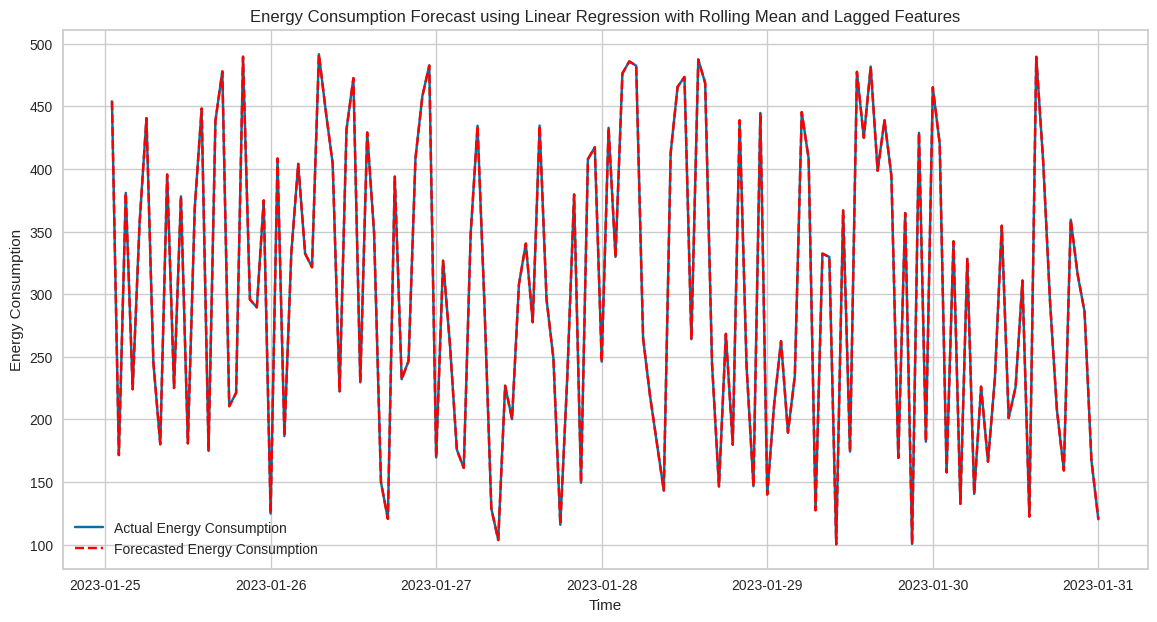

(1.2875191666777854e-25, 3.4747513508490455e-13, 1.0)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load your dataset
energy_data = pd.read_csv('/content/energy_consumption_data.csv')

# Assuming the 'timestamp' column exists and is used as index
energy_data['timestamp'] = pd.to_datetime(energy_data['timestamp'])
energy_data.set_index('timestamp', inplace=True)


# Create Rolling Means and Lagged Features
rolling_mean_2h = energy_data['energy_consumption'].rolling(window=2).mean()
rolling_mean_3h = energy_data['energy_consumption'].rolling(window=3).mean()
lag_1h = energy_data['energy_consumption'].shift(1)
lag_2h = energy_data['energy_consumption'].shift(2)

# Combine the Features into a Single DataFrame
combined_data = pd.DataFrame({
    'original': energy_data['energy_consumption'],
    'rolling_mean_2h': rolling_mean_2h,
    'rolling_mean_3h': rolling_mean_3h,
    'lag_1h': lag_1h,
    'lag_2h': lag_2h
}).dropna()

# Train-Test Split
train_size = int(len(combined_data) * 0.8)
train_data = combined_data.iloc[:train_size]
test_data = combined_data.iloc[train_size:]

X_train = train_data[['rolling_mean_2h', 'rolling_mean_3h', 'lag_1h', 'lag_2h']]
y_train = train_data['original']

X_test = test_data[['rolling_mean_2h', 'rolling_mean_3h', 'lag_1h', 'lag_2h']]
y_test = test_data['original']

# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Forecast using the Trained Model
forecast = model.predict(X_test)

# Plot the Results
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual Energy Consumption')
plt.plot(test_data.index, forecast, label='Forecasted Energy Consumption', linestyle='--', color='red')
plt.title('Energy Consumption Forecast using Linear Regression with Rolling Mean and Lagged Features')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate accuracy metrics
mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

# Display the results
mse, mae, r2


[307.05993858386984, 324.3163745396347]


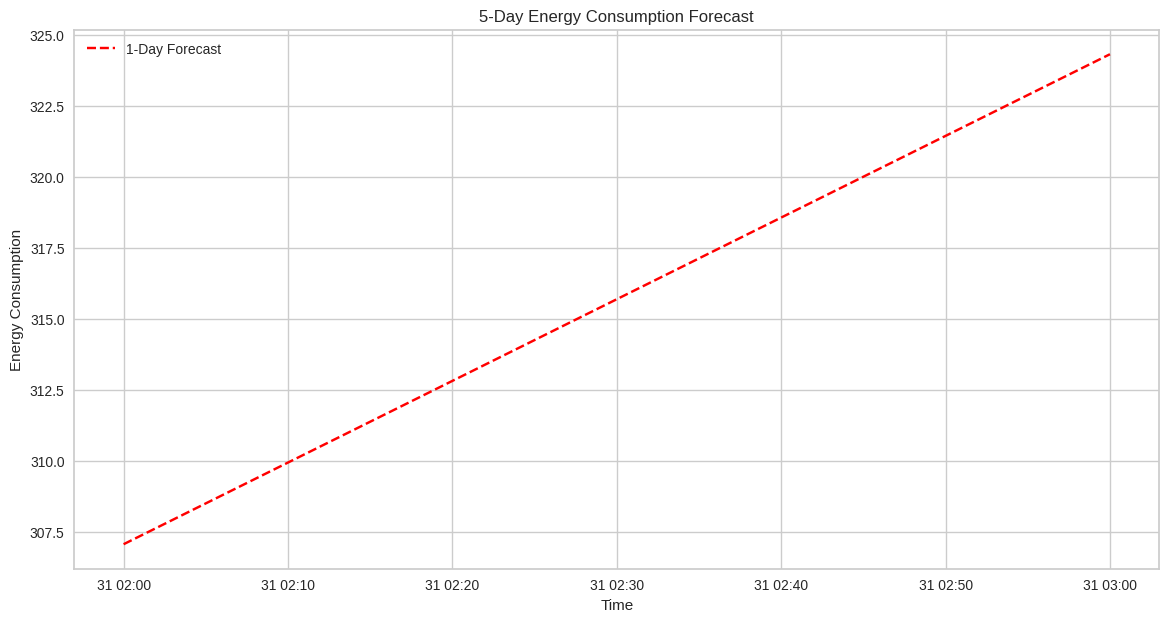

Forecasted Value For Hour 1: 307.05993858386984
Forecasted Value For Hour 2: 324.3163745396347


In [11]:
# Forecasting the Next 5 Days (120 hours)
forecast_horizon = 3
last_data_point = combined_data.iloc[-3]

forecast_values = []
for _ in range(forecast_horizon):
    # Create features from the last known data point
    features = np.array([
        last_data_point['rolling_mean_2h'],
        last_data_point['rolling_mean_3h'],
        last_data_point['lag_1h'],
        last_data_point['lag_2h']
    ]).reshape(1, -1)

    # Predict the next value
    next_value = model.predict(features)[0]
    forecast_values.append(next_value)

    # Update rolling means and lagged features
    new_rolling_mean_2h = (last_data_point['rolling_mean_2h'] + next_value) / 2
    new_rolling_mean_3h = (last_data_point['rolling_mean_3h'] * 2 + next_value) / 3
    new_lag_1h = last_data_point['original']
    new_lag_2h = last_data_point['lag_1h']

    # Create a new data point for the next iteration
    last_data_point = pd.Series({
        'original': next_value,
        'rolling_mean_2h': new_rolling_mean_2h,
        'rolling_mean_3h': new_rolling_mean_3h,
        'lag_1h': new_lag_1h,
        'lag_2h': new_lag_2h
    })

# Generate a date range for the forecast
forecast_index = pd.date_range(start=combined_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='H')

print(forecast_values[1:])
# Plot the 5-day forecast
plt.figure(figsize=(14, 7))
plt.plot(forecast_index[1:], forecast_values[1:], label='1-Day Forecast', linestyle='--', color='red')
plt.title('5-Day Energy Consumption Forecast')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


for n, value in zip(forecast_index[1:], forecast_values[1:]):
    print(f"Forecasted Value For Hour {n.hour -1 }: {value}")

#Random Forest

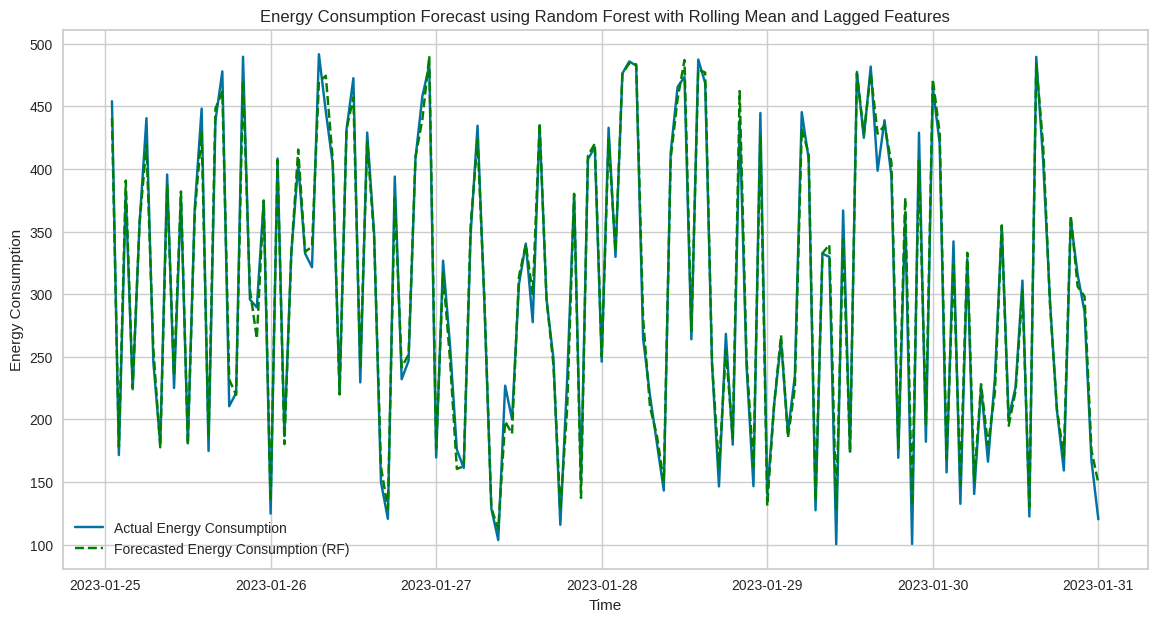

(140.7005932137621, 9.279047878993042, 0.9900067839824908)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your dataset
energy_data = pd.read_csv('/content/energy_consumption_data.csv')
# Assuming the 'timestamp' column exists and is used as index
energy_data['timestamp'] = pd.to_datetime(energy_data['timestamp'])
energy_data.set_index('timestamp', inplace=True)

# Step 1: Create Rolling Means and Lagged Features
rolling_mean_2h = energy_data['energy_consumption'].rolling(window=2).mean()
rolling_mean_3h = energy_data['energy_consumption'].rolling(window=3).mean()
lag_1h = energy_data['energy_consumption'].shift(1)
lag_2h = energy_data['energy_consumption'].shift(2)

# Step 2: Combine the Features into a Single DataFrame
combined_data = pd.DataFrame({
    'original': energy_data['energy_consumption'],
    'rolling_mean_2h': rolling_mean_2h,
    'rolling_mean_3h': rolling_mean_3h,
    'lag_1h': lag_1h,
    'lag_2h': lag_2h
}).dropna()

# Step 3: Train-Test Split
train_size = int(len(combined_data) * 0.8)
train_data = combined_data.iloc[:train_size]
test_data = combined_data.iloc[train_size:]

X_train = train_data[['rolling_mean_2h', 'rolling_mean_3h', 'lag_1h', 'lag_2h']]
y_train = train_data['original']

X_test = test_data[['rolling_mean_2h', 'rolling_mean_3h', 'lag_1h', 'lag_2h']]
y_test = test_data['original']

# Step 4: Train the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Forecast using the Trained Random Forest Model
rf_forecast = rf_model.predict(X_test)

# Step 6: Plot the Results
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual Energy Consumption')
plt.plot(test_data.index, rf_forecast, label='Forecasted Energy Consumption (RF)', linestyle='--', color='green')
plt.title('Energy Consumption Forecast using Random Forest with Rolling Mean and Lagged Features')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# Step 7: Calculate Accuracy Metrics
rf_mse = mean_squared_error(y_test, rf_forecast)
rf_mae = mean_absolute_error(y_test, rf_forecast)
rf_r2 = r2_score(y_test, rf_forecast)

# Display the results

rf_mse, rf_mae, rf_r2


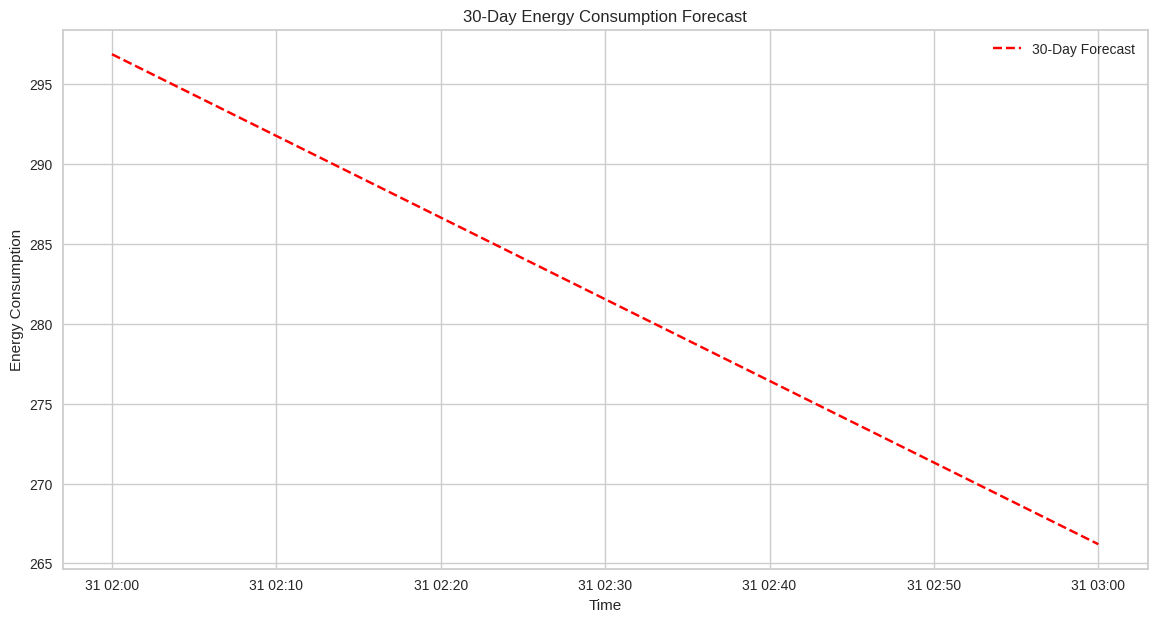

Forecasted Value For Hour 1: 296.8852617128781
Forecasted Value For Hour 2: 266.20017584849836


In [13]:
forecast_horizon = 3 # Number of hours to forecast (3 hours)
last_data_point = combined_data.iloc[-3]

forecast_values = []
for _ in range(forecast_horizon):
    # Create features from the last known data point
    features = np.array([
        last_data_point['rolling_mean_2h'],
        last_data_point['rolling_mean_3h'],
        last_data_point['lag_1h'],
        last_data_point['lag_2h']
    ]).reshape(1, -1)

    # Predict the next value
    next_value = rf_model.predict(features)[0]
    forecast_values.append(next_value)

    # Update rolling means and lagged features
    new_rolling_mean_2h = (last_data_point['rolling_mean_2h'] + next_value) / 2
    new_rolling_mean_3h = (last_data_point['rolling_mean_3h'] * 2 + next_value) / 3
    new_lag_1h = last_data_point['original']
    new_lag_2h = last_data_point['lag_1h']

    # Create a new data point for the next iteration
    last_data_point = pd.Series({
        'original': next_value,
        'rolling_mean_2h': new_rolling_mean_2h,
        'rolling_mean_3h': new_rolling_mean_3h,
        'lag_1h': new_lag_1h,
        'lag_2h': new_lag_2h
    })

# Generate a date range for the forecast
forecast_index = pd.date_range(start=combined_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='H')

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(forecast_index[1:], forecast_values[1:], label='30-Day Forecast', linestyle='--', color='red')
plt.title('30-Day Energy Consumption Forecast')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

for n, value in zip(forecast_index[1:], forecast_values[1:]):
    print(f"Forecasted Value For Hour {n.hour -1 }: {value}")


#LSTM

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the dataset
file_path = '/content/energy_consumption_data.csv'
data = pd.read_csv(file_path)

# Prepare the data
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.rename(columns={'timestamp': 'ds', 'energy_consumption': 'y'})

# Create Additional Features
data['hour'] = data['ds'].dt.hour
data['day_of_week'] = data['ds'].dt.dayofweek
data['month'] = data['ds'].dt.month
data['rolling_mean_2h'] = data['y'].rolling(window=2).mean().shift(1)
data['rolling_mean_3h'] = data['y'].rolling(window=3).mean().shift(1)
data['lag_1h'] = data['y'].shift(1)
data['lag_2h'] = data['y'].shift(2)

# Drop NaN values resulting from the shifts
data = data.dropna()

# Train-Test Split
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Scale the Features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(train[['y', 'rolling_mean_2h', 'rolling_mean_3h', 'lag_1h', 'lag_2h']])
scaled_test = scaler.transform(test[['y', 'rolling_mean_2h', 'rolling_mean_3h', 'lag_1h', 'lag_2h']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:])  # Use all features except the target (y)
        y.append(data[i+seq_length, 0])  # The target is the 'y' column
    return np.array(X), np.array(y)

seq_length = 24  # Using last 24 hours to predict the next one
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM Model
lstm_model = Sequential()

lstm_model.add(LSTM(512, return_sequences=True, input_shape=(seq_length, X_train.shape[2]), kernel_regularizer=l2(0.01)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(64, activation='tanh', kernel_regularizer=l2(0.01)))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(1))

optimizer = Adam(learning_rate=0.00001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the LSTM Model

######### Uncomment this line #########

# lstm_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

#######################################


# Forecast using LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], scaled_test.shape[1]-1))), axis=1))[:, 0]

# Plot the Results
# plt.figure(figsize=(14, 8))
# plt.plot(test['ds'].iloc[seq_length:], test['y'].iloc[seq_length:], label='Actual')
# plt.plot(test['ds'].iloc[seq_length:], lstm_predictions, label='LSTM Forecast', color='red')
# plt.title('LSTM Forecast with All Features')
# plt.legend()
# plt.show()
